In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision.transforms import v2
from PIL import Image

In [2]:
!git clone "https://github.com/Bhavnoor-Coders-1010/DeepFakeBCS" deepfake

class DataDeepFake(Dataset):
    def __init__(self):
        self.fakeImagesLocation = "./deepfake/faketrain/"
        self.realImagesLocation = "./deepfake/realtrain/"
        self.fake = os.listdir(self.fakeImagesLocation)
        self.real = os.listdir(self.realImagesLocation)
        self.basic = v2.Compose([v2.Resize((224,224)),v2.ToTensor()])
        self.t0 = v2.Resize((224,224))
        self.t1 = v2.RandomHorizontalFlip(p=0.5)
        self.t2 = v2.RandomVerticalFlip(p=0.5)
        self.t3 = v2.RandomAffine(degrees=(-30, 30), shear=(0.75, 1.25, 0.75, 1.25))
        self.t4 = v2.ColorJitter(brightness=(0.75, 1.25), contrast=0, saturation=0, hue=0)
        self.tFinal = v2.Compose([self.t1, self.t2, self.t3, self.t4, self.t0, v2.Resize((224,224)), v2.ToTensor()])
        pass
    def __len__(self):
        return len(self.fake) + len(self.real)
    def __getitem__(self, idx):
        if(idx>=len(self.fake)+(len(self.real)//2)):
            img = Image.open(self.realImagesLocation+self.real[idx%len(self.fake)])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            img = self.tFinal(img)
            return img, torch.Tensor([0])
        elif(idx>=len(self.fake)):
            img = Image.open(self.realImagesLocation+self.real[idx%len(self.fake)])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            img = self.basic(img)
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            return img, torch.Tensor([1])
        elif(idx>=len(self.fake)//2):
            img = Image.open(self.fakeImagesLocation+self.fake[idx])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            img = self.tFinal(img)
            return img, torch.Tensor([0])
        else:
            img = Image.open(self.fakeImagesLocation+self.fake[idx])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            img = self.basic(img)
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            return img, torch.Tensor([1])
dataset = DataDeepFake()

Cloning into 'deepfake'...
remote: Enumerating objects: 26814, done.
remote: Counting objects: 100% (7172/7172), done.
remote: Compressing objects: 100% (7168/7168), done.
remote: Total 26814 (delta 3), reused 7170 (delta 1), pack-reused 19642 (from 1)
Receiving objects: 100% (26814/26814), 246.87 MiB | 37.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (27059/27059), done.


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:

# Split metadata into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)


# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


10962


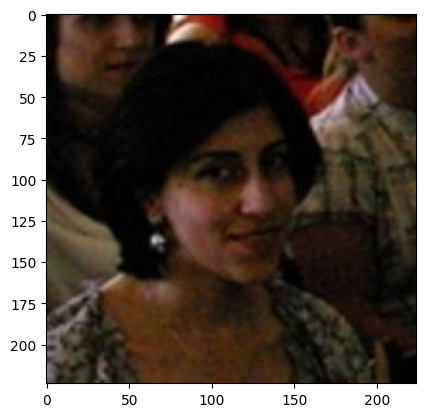

In [4]:
imageNumber = np.random.randint(0,19000)
plt.imshow(dataset[imageNumber][0].permute(1,2,0))
print(imageNumber)

In [5]:
class DeepfakeNet(nn.Module):
    def __init__(self):
        super(DeepfakeNet, self).__init__()
#         self.drp = nn.Dropout(0.4)#------------------------------------------------------------------------------------------------------------------------
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layers = nn.ModuleList([Bottleneck(64, 256, first=True)])
        self.out_size = [256,512,1024,2048]
        self.blocks = [1,2,2,1]
        for i in range(len(self.out_size)):
            if i > 0:
                self.layers.append(Bottleneck(self.out_size[i-1], self.out_size[i], 2))
            for extraLayers in range(self.blocks[i]-1):
                self.layers.append(Bottleneck(self.out_size[i], self.out_size[i]))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, 1)
        
        
        
    def _make_layer(self, in_channels, out_channels, blocks):
        layers = []
        for _ in range(blocks):                
            layers.append(Bottleneck(in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
#         x = self.drp(x)#------------------------------------------------------------------------------------------------------------------------------------
        x = self.conv1(x)
        x = self.maxpool(x)
        for layer in self.layers:
            x = layer(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [6]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, first=False):
        super(Bottleneck, self).__init__()
        mid_channels = out_channels//2
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=mid_channels, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, out_channels=mid_channels, kernel_size=3, padding=1, groups=32, stride=stride)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(in_channels=mid_channels, out_channels=out_channels, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = stride == 2 or first 
        if self.downsample:
            self.changeInputC2D = nn.Conv2d(in_channels = in_channels, out_channels=out_channels, kernel_size=1, stride=stride)
            self.changeInputBn = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample:
            residual = self.changeInputC2D(residual)
            residual = self.changeInputBn(residual)
        out = torch.add(out, residual)
        out = self.relu(out)
        return out



In [7]:
training_loss = []
validation_loss = []
validation_acc = []

In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Calculate average loss
    avg_loss = running_loss / len(dataloader)
    training_loss.append(avg_loss)
    return avg_loss

In [9]:
def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)

            # Accumulate loss
            val_loss += loss.item()

            # Calculate accuracy
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy
    avg_loss = val_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    validation_loss.append(avg_loss)
    validation_acc.append(accuracy)
    return avg_loss, accuracy

In [10]:
# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your model, optimizer, and criterion
model = DeepfakeNet()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.MSELoss()  # Assuming binary classification (1 output unit)

# Move model to device
model.to(device)
num_epochs = 20


In [11]:
!pip install torchsummary
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
         MaxPool2d-2           [-1, 64, 56, 56]               0
            Conv2d-3          [-1, 128, 56, 56]           8,320
       BatchNorm2d-4          [-1, 128, 56, 56]             256
              ReLU-5          [-1, 128, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]           4,736
       BatchNorm2d-7          [-1, 128, 56, 56]             256
              ReLU-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]          33,024
      BatchNorm2d-10          [-1, 256, 56, 56]             512
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
       Bottleneck-14          [-1, 256,

In [12]:
training_loss = []
validation_loss = []
validation_acc = []
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")


# Optionally, save your model
# torch.save(model.state_dict(), 'model.pth')

Epoch 1/20


Training Loss: 0.0681 | Validation Loss: 0.0293 | Validation Accuracy: 97.87%
Epoch 2/20


Training Loss: 0.0274 | Validation Loss: 0.0232 | Validation Accuracy: 99.05%
Epoch 3/20


Training Loss: 0.0194 | Validation Loss: 0.0260 | Validation Accuracy: 98.84%
Epoch 4/20


Training Loss: 0.0158 | Validation Loss: 0.0175 | Validation Accuracy: 99.37%
Epoch 5/20


Training Loss: 0.0124 | Validation Loss: 0.0131 | Validation Accuracy: 99.57%
Epoch 6/20


Training Loss: 0.0100 | Validation Loss: 0.0127 | Validation Accuracy: 99.57%
Epoch 7/20


Training Loss: 0.0080 | Validation Loss: 0.0114 | Validation Accuracy: 99.67%
Epoch 8/20


Training Loss: 0.0067 | Validation Loss: 0.0128 | Validation Accuracy: 99.67%
Epoch 9/20


Training Loss: 0.0059 | Validation Loss: 0.0116 | Validation Accuracy: 99.65%
Epoch 10/20


Training Loss: 0.0048 | Validation Loss: 0.0132 | Validation Accuracy: 99.75%
Epoch 11/20


Training Loss: 0.0041 | Validation Loss: 0.0252 | Validation Accuracy: 99.45%
Epoch 12/20


Training Loss: 0.0038 | Validation Loss: 0.0125 | Validation Accuracy: 99.67%
Epoch 13/20


Training Loss: 0.0031 | Validation Loss: 0.0087 | Validation Accuracy: 99.72%
Epoch 14/20


Training Loss: 0.0028 | Validation Loss: 0.0081 | Validation Accuracy: 99.75%
Epoch 15/20


Training Loss: 0.0026 | Validation Loss: 0.0081 | Validation Accuracy: 99.75%
Epoch 16/20


Training Loss: 0.0024 | Validation Loss: 0.0209 | Validation Accuracy: 99.72%
Epoch 17/20


Training Loss: 0.0023 | Validation Loss: 0.0077 | Validation Accuracy: 99.77%
Epoch 18/20


Training Loss: 0.0021 | Validation Loss: 0.0075 | Validation Accuracy: 99.85%
Epoch 19/20


Training Loss: 0.0020 | Validation Loss: 0.0104 | Validation Accuracy: 99.75%
Epoch 20/20


Training Loss: 0.0018 | Validation Loss: 0.0172 | Validation Accuracy: 99.67%


In [13]:
epochs = list(range(1,num_epochs+1))

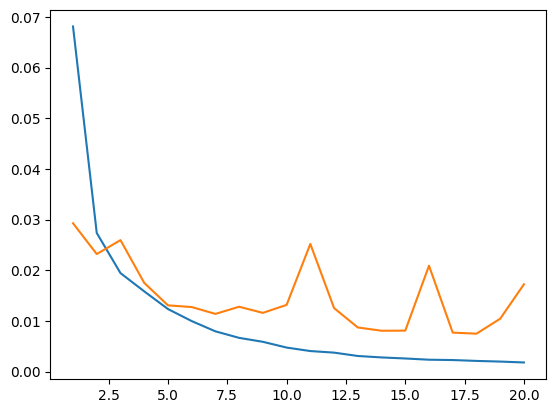

In [14]:
plt.plot(epochs, training_loss)
plt.plot(epochs, validation_loss)

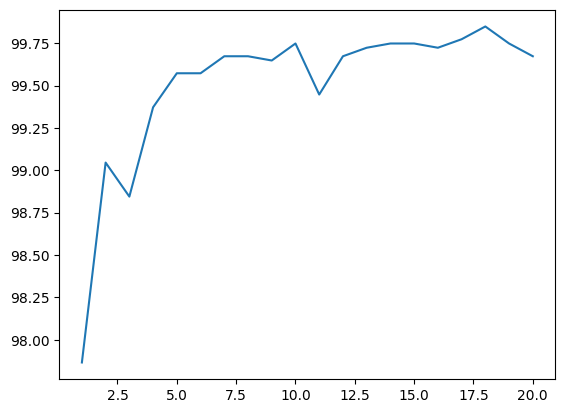

In [15]:
plt.plot(epochs, validation_acc)

In [16]:
torch.save(model, '/kaggle/working/DeepFakeBCSNewFullModel.pth')

In [17]:
class TestData(Dataset):
    def __init__(self):
        self.fakeImagesLocation = "./deepfake/DF and Real/DF/"
        self.realImagesLocation = "./deepfake/DF and Real/Real/"
        self.fake = os.listdir(self.fakeImagesLocation)
        self.real = os.listdir(self.realImagesLocation)
        self.basic = v2.Compose([v2.Resize((224,224)),v2.ToTensor()])
        self.t0 = v2.Resize((224,224))
        self.t1 = v2.RandomHorizontalFlip(p=0.5)
        self.t2 = v2.RandomVerticalFlip(p=0.5)
        self.t3 = v2.RandomAffine(degrees=(-30, 30), shear=(0.75, 1.25, 0.75, 1.25))
        self.t4 = v2.ColorJitter(brightness=(0.75, 1.25), contrast=0, saturation=0, hue=0)
        self.tFinal = v2.Compose([self.t1, self.t2, self.t3, self.t4, self.t0, v2.Resize((224,224)), v2.ToTensor()])
        pass
    def __len__(self):
        return len(self.fake) + len(self.real)
    def __getitem__(self, idx):
        if(idx>=len(self.fake)+(len(self.real)//2)):
            img = Image.open(self.realImagesLocation+self.real[idx%len(self.fake)])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            img = self.tFinal(img)
            return img, torch.Tensor([0])
        elif(idx>=len(self.fake)):
            img = Image.open(self.realImagesLocation+self.real[idx%len(self.fake)])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            img = self.basic(img)
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            return img, torch.Tensor([1])
        elif(idx>=len(self.fake)//2):
            img = Image.open(self.fakeImagesLocation+self.fake[idx])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            img = self.tFinal(img)
            return img, torch.Tensor([0])
        else:
            img = Image.open(self.fakeImagesLocation+self.fake[idx])
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img.resize((224, 224))
            img = self.basic(img)
            # img = torch.Tensor(img)
            # img = img.permute(2,0,1) #np.swapaxes(img, 0,2)
            return img, torch.Tensor([1])

In [18]:
test_data = TestData()
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

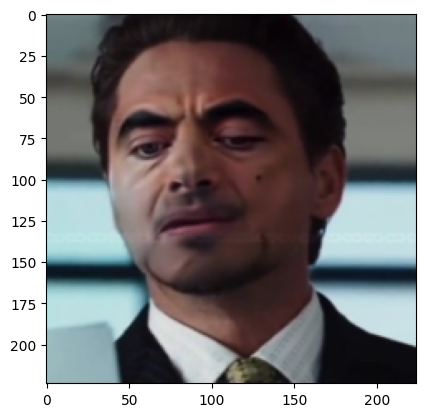

In [19]:
plt.imshow(test_data[0][0].permute(1,2,0))

In [20]:
evaluate(model, test_loader, criterion, device)

(0.020517608771721523, 100.0)